dataset used here: 5000 movie dataset



Training and tuning SVM...

=== SVM ===
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.6123348017621145
Confusion Matrix:
 [[249  79  20  20]
 [ 59  91  30   8]
 [ 19  31  54  20]
 [ 24  16  26 162]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.69       368
           1       0.42      0.48      0.45       188
           2       0.42      0.44      0.43       124
           3       0.77      0.71      0.74       228

    accuracy                           0.61       908
   macro avg       0.58      0.58      0.58       908
weighted avg       0.62      0.61      0.62       908



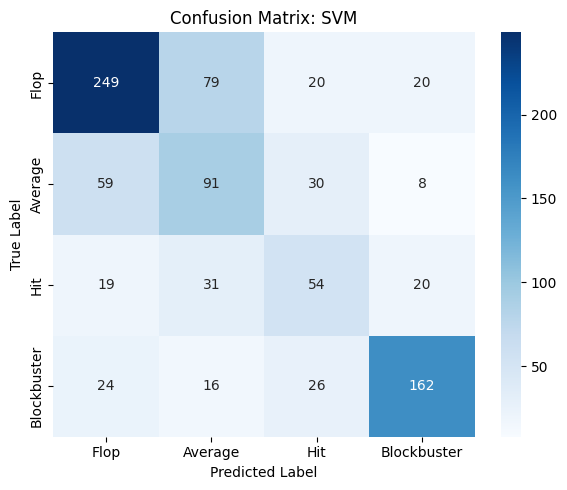

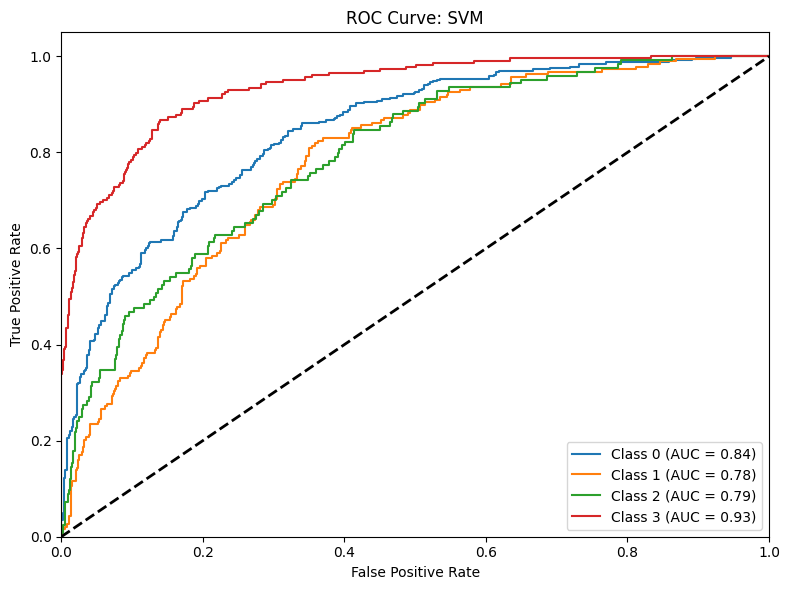


Training and tuning Random Forest...

=== Random Forest ===
Best Parameters: {'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.6850220264317181
Confusion Matrix:
 [[266  71  21  10]
 [ 47 102  36   3]
 [ 13  33  61  17]
 [ 12   8  15 193]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       368
           1       0.48      0.54      0.51       188
           2       0.46      0.49      0.47       124
           3       0.87      0.85      0.86       228

    accuracy                           0.69       908
   macro avg       0.65      0.65      0.65       908
weighted avg       0.70      0.69      0.69       908



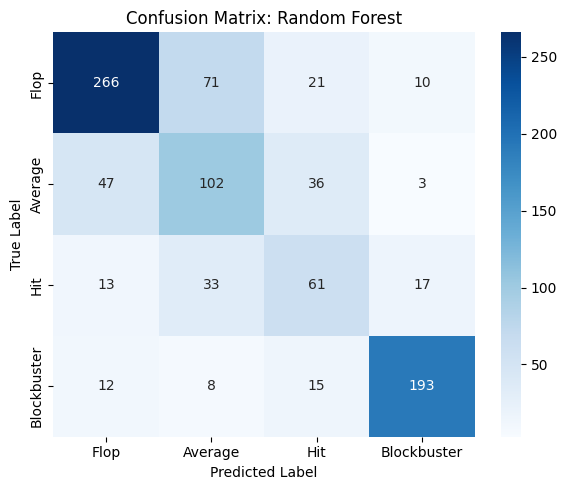

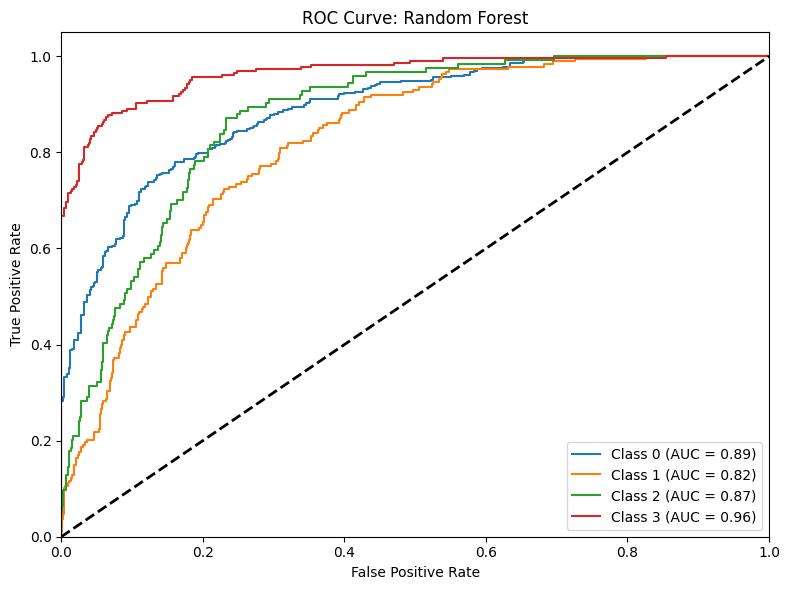


Training and tuning Decision Tree...

=== Decision Tree ===
Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
Accuracy: 0.6387665198237885
Confusion Matrix:
 [[223 101  24  20]
 [ 38 111  36   3]
 [  6  33  74  11]
 [  5  12  39 172]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.61      0.70       368
           1       0.43      0.59      0.50       188
           2       0.43      0.60      0.50       124
           3       0.83      0.75      0.79       228

    accuracy                           0.64       908
   macro avg       0.63      0.64      0.62       908
weighted avg       0.69      0.64      0.65       908



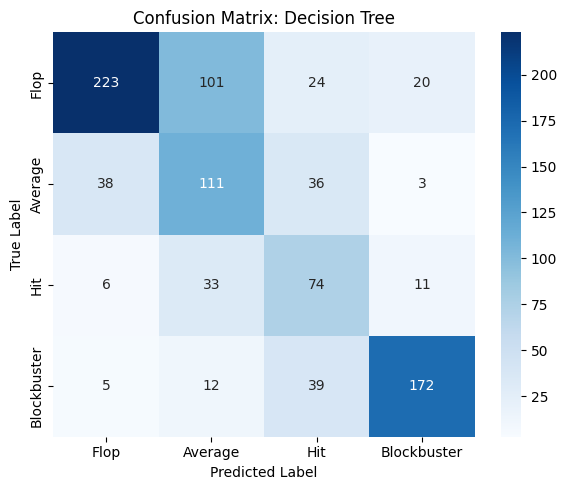

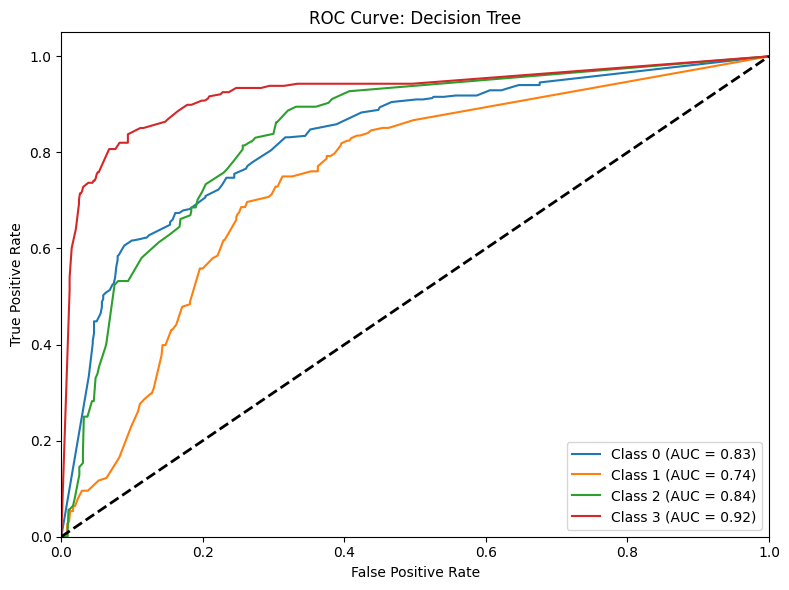


Training and tuning Logistic Regression...

=== Logistic Regression ===
Best Parameters: {'C': 10}
Accuracy: 0.6156387665198237
Confusion Matrix:
 [[229  61  54  24]
 [ 55  81  43   9]
 [ 20  15  73  16]
 [ 17   7  28 176]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.66       368
           1       0.49      0.43      0.46       188
           2       0.37      0.59      0.45       124
           3       0.78      0.77      0.78       228

    accuracy                           0.62       908
   macro avg       0.59      0.60      0.59       908
weighted avg       0.64      0.62      0.62       908



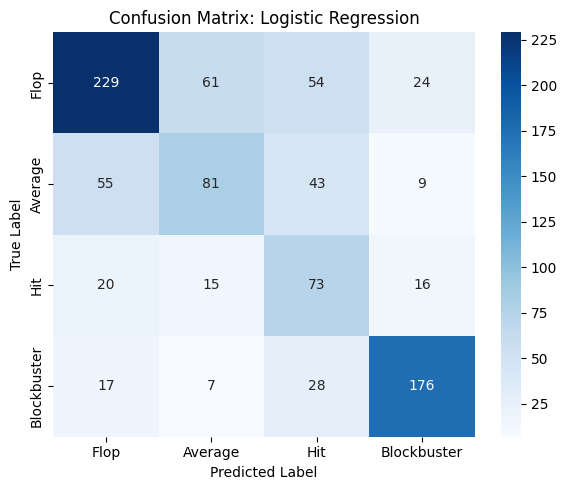

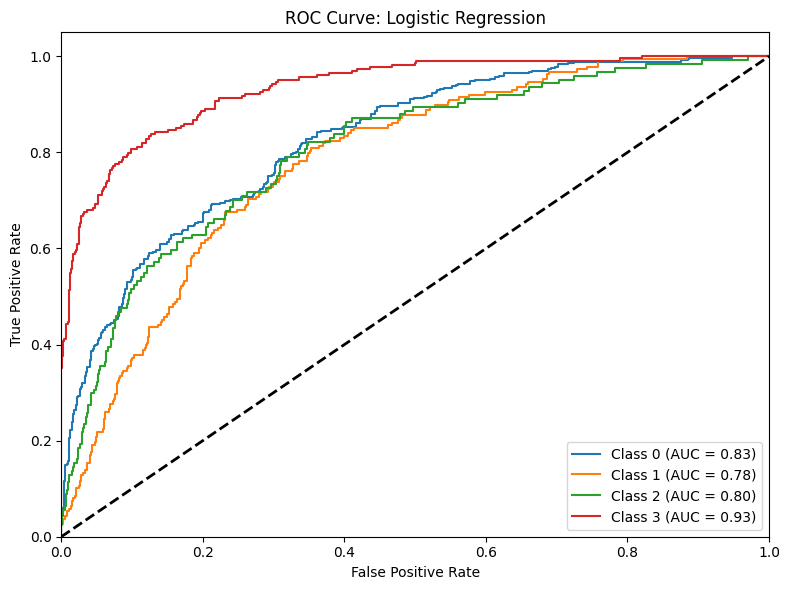


Training and tuning Gradient Boosting...

=== Gradient Boosting ===
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
Accuracy: 0.7081497797356828
Confusion Matrix:
 [[268  67  18  15]
 [ 60  97  28   3]
 [  9  29  76  10]
 [  7   3  16 202]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75       368
           1       0.49      0.52      0.51       188
           2       0.55      0.61      0.58       124
           3       0.88      0.89      0.88       228

    accuracy                           0.71       908
   macro avg       0.68      0.69      0.68       908
weighted avg       0.71      0.71      0.71       908



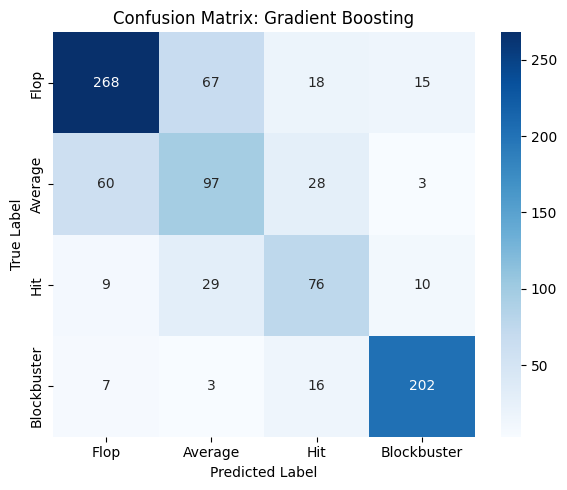

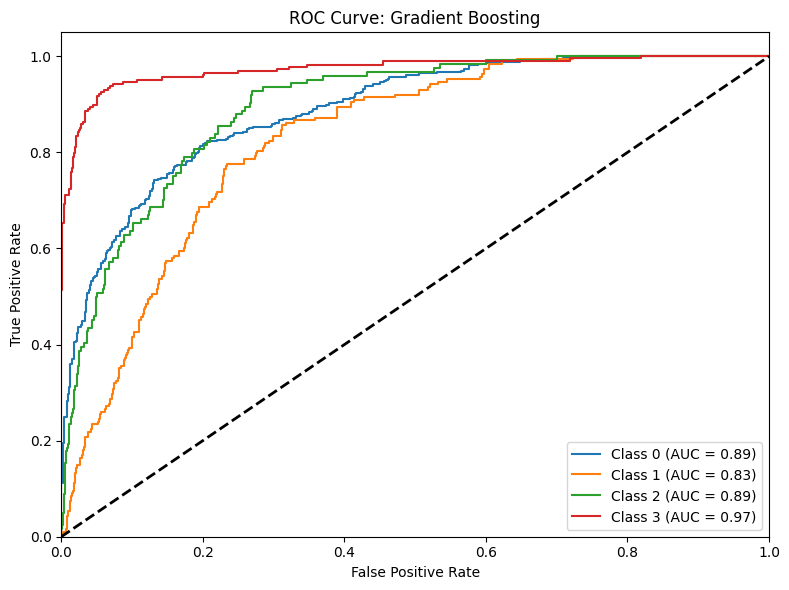

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE

def compare_algorithms(file_path):
    df = pd.read_csv(file_path)

    # Drop rows with essential missing values
    df = df[['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
             'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
             'budget', 'genres', 'plot_keywords', 'content_rating', 'duration', 'gross',
             'title_year', 'country']].copy()
    df = df.dropna(subset=['director_name', 'actor_1_name', 'budget', 'genres'])

    # Director success score (average gross)
    director_gross = df.groupby('director_name')['gross'].mean().to_dict()
    df['director_success_score'] = df['director_name'].map(director_gross)

    # Actor success score (mean of past gross)
    actors = pd.concat([
        df[['actor_1_name', 'gross']].rename(columns={'actor_1_name': 'actor'}),
        df[['actor_2_name', 'gross']].rename(columns={'actor_2_name': 'actor'}),
        df[['actor_3_name', 'gross']].rename(columns={'actor_3_name': 'actor'})
    ])
    actor_success_dict = actors.groupby('actor')['gross'].mean().to_dict()
    df['actor_success_score'] = df[['actor_1_name', 'actor_2_name', 'actor_3_name']].apply(
        lambda row: np.mean([actor_success_dict.get(name, 0) for name in row]), axis=1)

    # Star power (average of FB likes)
    df['star_power'] = df[['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']].mean(axis=1)

    # Genre count
    df['genre_count'] = df['genres'].apply(lambda x: len(str(x).split('|')))

    # Keyword processing
    df['plot_keywords'] = df['plot_keywords'].fillna('')  # Avoid inplace
    df['plot_keywords'] = df['plot_keywords'].apply(lambda x: [kw.strip().lower() for kw in x.split('|') if kw.strip()])

    all_keywords = Counter([kw for keywords in df['plot_keywords'] for kw in keywords])
    top_keywords = [kw for kw, count in all_keywords.most_common(30)]
    for kw in top_keywords:
        df[f'kw_{kw}'] = df['plot_keywords'].apply(lambda kws: int(kw in kws))

    # Keyword count
    df['keyword_count'] = df['plot_keywords'].apply(lambda x: len(x))

    # Release decade
    df['title_year'] = df['title_year'].fillna(df['title_year'].median())  # Avoid inplace
    df['release_decade'] = (df['title_year'] // 10) * 10

    # Country encoding
    df['country'] = df['country'].fillna('Unknown')  # Avoid inplace
    top_countries = df['country'].value_counts().nlargest(5).index
    df['country'] = df['country'].apply(lambda x: x if x in top_countries else 'Other')

    # Target: success classification based on gross/budget ratio
    def classify_success(row):
        if row['gross'] <= 0 or row['budget'] <= 0:
            return 0
        ratio = row['gross'] / row['budget']
        if ratio < 1:
            return 0  # Flop
        elif ratio < 2:
            return 1  # Average
        elif ratio < 4:
            return 2  # Hit
        else:
            return 3  # Blockbuster

    df['success'] = df.apply(classify_success, axis=1)

    # Drop unused columns
    df.drop(columns=[
        'gross', 'director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name',
        'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
        'genres', 'plot_keywords', 'title_year'
    ], inplace=True)

    # Define features and target
    X = df.drop(columns=['success'])
    y = df['success'].astype(int)

    # Columns by type
    numeric_features = ['budget', 'duration', 'director_success_score',
                        'actor_success_score', 'star_power', 'genre_count', 'keyword_count']
    keyword_features = [col for col in df.columns if col.startswith('kw_')]
    categorical_features = ['content_rating', 'release_decade', 'country']

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('kw', 'passthrough', keyword_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

    # Preprocess features
    X_processed = preprocessor.fit_transform(X)

    # Split data (stratify to keep class distribution)
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y, stratify=y, test_size=0.2, random_state=42
    )

    # Apply SMOTE on training data only
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Models and parameter grids including Gradient Boosting
    models = {
        'SVM': SVC(probability=True),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }

    param_grid = {
        'SVM': {'C': [0.1, 1, 10], 'gamma': ['scale'], 'kernel': ['rbf']},
        'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [10]},
        'Decision Tree': {'max_depth': [5, 10], 'min_samples_split': [10]},
        'Logistic Regression': {'C': [0.1, 1, 10]},
        'Gradient Boosting': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
    }

    # Evaluate each model
    labels = ['Flop', 'Average', 'Hit', 'Blockbuster']
    classes = list(range(4))  # assuming 0 to 3
    for name, model in models.items():
        print(f"\nTraining and tuning {name}...")
        grid = GridSearchCV(model, param_grid[name], cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_resampled, y_train_resampled)
        y_pred = grid.predict(X_test)

        print(f"\n=== {name} ===")
        print("Best Parameters:", grid.best_params_)
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("Classification Report:\n", classification_report(y_test, y_pred))

        plot_confusion_matrix(y_test, y_pred, name, labels)
        plot_multiclass_roc(grid.best_estimator_, X_test, y_test, name, classes)


# Example usage:
compare_algorithms('movie_metadata.csv')


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix(y_true, y_pred, model_name, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

def plot_multiclass_roc(model, X_test, y_test, model_name, classes):
    if not hasattr(model, "predict_proba"):
        print(f"{model_name} does not support probability predictions.")
        return

    y_test_bin = label_binarize(y_test, classes=classes)
    y_score = model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f"ROC Curve: {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
